## Libraries I used




*   scikit-learn
*   pandas
*   keras
*   matplotlib
*   numpy

## Data wrangling


In [0]:
# import packages
import numpy as np
import pandas as pd
from numpy.random import randn
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
import datetime as dt
from matplotlib import style
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [0]:
# upload csv file 
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [0]:
# read the data and treat the DATE_TIME as the index instead of a column
raw_data = pd.read_csv("dataset.csv")
raw_data.DATE_TIME= pd.to_datetime(raw_data.DATE_TIME)
raw_data=raw_data.set_index('DATE_TIME')
raw_data.describe()

,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Total_Demand lag 0
count,102333.000000,102333.000000,102333.000000,102333.000000,102234.000000,102277.000000,87403.000000
mean,0.031896,0.029082,0.015049,0.014541,5.438484,0.066962,477.362838
std,0.175724,0.168036,0.121748,0.119706,10.619909,0.683921,167.144286
min,0.000000,0.000000,0.000000,0.000000,-29.300000,-99.000000,-3794.500185
25%,0.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,377.590608
50%,0.000000,0.000000,0.000000,0.000000,5.900000,0.000000,508.842211
75%,0.000000,0.000000,0.000000,0.000000,12.800000,0.030500,578.978096
max,1.000000,1.000000,1.000000,1.000000,32.900000,6.941800,4829.563921


In [0]:
# since we already know that there are NaNs at the beginning and the end, I'll store the data and the NaNs at the end into the dataframe "data_1"
df = raw_data[raw_data["Total_Demand lag 0"].first_valid_index():]

# check to make sure they are not NaN
df.head(10)

In [0]:
# we can see that after the first two rows, there are still a lot of NaNs, so I need to remove them as well
first_index = df[2:-1]["Total_Demand lag 0"].first_valid_index() 

# data_pred is the dataframe without the NaN at the beginning but with NaNs at the end 
data_pred = raw_data[first_index:]

# data is the dataframe without the NaN at the beginning nor at the end, last_valid_3 is the last valid index in data_2 
last_index = data_pred["Total_Demand lag 0"].last_valid_index() 
data = data_pred[:last_index]

In [0]:
# It's common sense that previpitation data cannot fall below 0, so I'll replace negative numbers with NaNs and deal with these NaNs later
data[data["previous_3_hour_max_precip"]<0] = np.nan

# there are a lot of extreme data in the water demand data, so I'll replace the outliers(outside 3 standard deviations) with NaNs and I'll deal with these NaNs later
data[(data["Total_Demand lag 0"]<477.362838-3*167.144286)] = np.nan
data[(data["Total_Demand lag 0"]>477.362838+3*167.144286)] = np.nan
     
# interpolate the missing data in the middle and replace them with the nearest data in the same column
data.interpolate(method='nearest', inplace=True)
data.to_csv("data.csv")

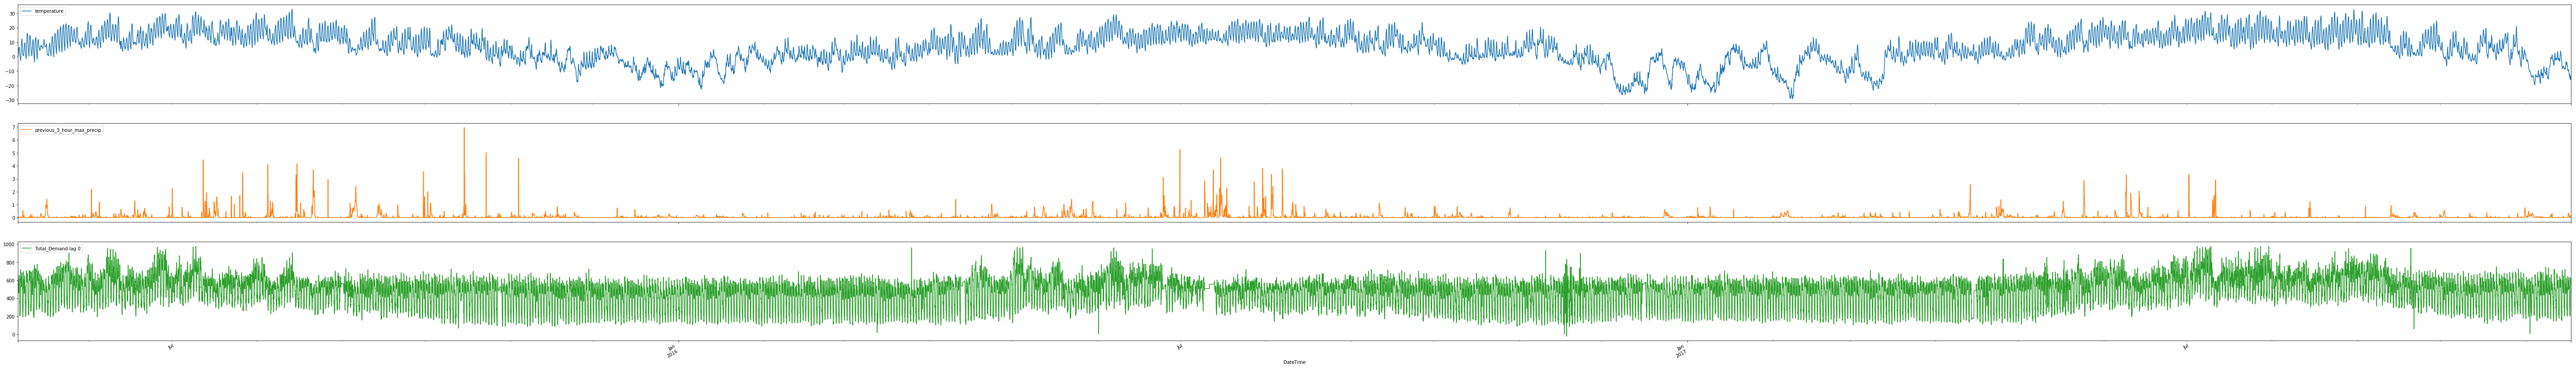

In [0]:
# this is what the cleaned dataset looks like, please scroll to the right if the monitor is not wide enough
%matplotlib inline

cols_plot = ['temperature', 'previous_3_hour_max_precip', 'Total_Demand lag 0']
axes = data[cols_plot].plot(figsize=(100, 15), subplots=True)
for ax in axes:
  ax.set_xlabel('DateTime')
  ax.legend(loc='upper left')

## Transform the dataset and build the LSTM model

**I created a graph to demonstrate how this transformation works** [link](https://drive.google.com/file/d/1kiPddUXdFFJK_p9sTqrsWP4q_DcVS1qu/view?usp=sharing)

In [0]:
"""
Frame a time series as a supervised learning dataset.
Inputs:
data: Sequence of observations as a list or NumPy array.
n_in: Number of lag observations as input (X).
n_out: Number of observations as output (y).
dropnan: Boolean whether or not to drop rows with NaN values.
Outputs:Pandas DataFrame of series framed for supervised learning.  

"""

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
  
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
      
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
  
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# cast the values in the dataframe into the variable values
values = data.values

# convert the data to float
values = values.astype('float32')
 
# use previosu 96 timesteps, which represent the data points in the past 24 hour
n_lag = 96
n_features = 7


# normalize features with Min Max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(reframed.head(), reframed.shape)

     var1(t-96)  var2(t-96)  var3(t-96)  ...   var5(t)   var6(t)   var7(t)
96          0.0         0.0         0.0  ...  0.432476  0.000000  0.687614
97          0.0         0.0         0.0  ...  0.438907  0.000000  0.634096
98          0.0         0.0         0.0  ...  0.443730  0.000000  0.637121
99          0.0         0.0         0.0  ...  0.448553  0.008053  0.617611
100         0.0         0.0         0.0  ...  0.459807  0.008053  0.593484

[5 rows x 679 columns] (88820, 679)


In [0]:
"""
for faster computation, I decided to use 80/20 split instead of sliding windows.
REMEMBER TO RUN THIS BLOCK to define the shape of the train/test
"""
values = scaled.values
n_train = int(88820*0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# cauculate the number of objects, which is useful for future indexing
n_obj = n_lag*n_features


# split into input and outputs, input is [batch size, timesteps, features]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# transform the matrix X so that X also include data from past timesteps
train_X =  series_to_supervised(train_X, n_lag, 1)
test_X =  series_to_supervised(test_X, n_lag, 1)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(71056, 96, 7) (71056,) (17764, 96, 7) (17764,)


Train on 71056 samples, validate on 17764 samples
Epoch 1/20
 - 73s - loss: 0.0189 - mean_squared_error: 0.0093 - val_loss: 0.0138 - val_mean_squared_error: 0.0033
Epoch 2/20
 - 72s - loss: 0.0083 - mean_squared_error: 0.0019 - val_loss: 0.0102 - val_mean_squared_error: 0.0026
Epoch 3/20
 - 72s - loss: 0.0070 - mean_squared_error: 0.0015 - val_loss: 0.0125 - val_mean_squared_error: 0.0020
Epoch 4/20
 - 71s - loss: 0.0057 - mean_squared_error: 0.0012 - val_loss: 0.0092 - val_mean_squared_error: 0.0019
Epoch 5/20
 - 71s - loss: 0.0048 - mean_squared_error: 0.0010 - val_loss: 0.0036 - val_mean_squared_error: 0.0012
Epoch 6/20
 - 71s - loss: 0.0047 - mean_squared_error: 9.8527e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0011
Epoch 7/20
 - 71s - loss: 0.0046 - mean_squared_error: 9.0039e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0010
Epoch 8/20
 - 71s - loss: 0.0044 - mean_squared_error: 8.3844e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0011
Epoch 9/20
 - 71s - loss: 

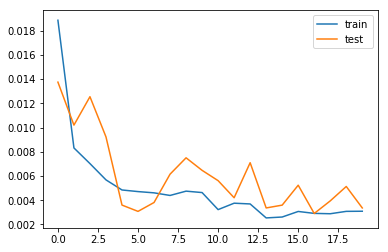

In [0]:
# LSTM network with 1 hidden layer
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mean_squared_error'])

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history to visualize accuracy
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))

# invert scaling to revert forecast numbers
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]


# invert scaling to revert actual numbers
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE to evaluate the model
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE:  47.363


## Predictions and Confidence Bound: I treated the raw data exactly in the same way that I treated the data for the LSTM model. This time, I am going to use all the valid data points as Training data and the next 96 data points as inference data.

In [0]:
# find out where is the last valid data point so that I can predict the next 96 timesteps
last_valid_pred = raw_data['Total_Demand lag 0'].last_valid_index()

# the dataframe "data_pred" will store the value from the very beggining of the data(in 2015) to the end of the 24-hour prediction period 
data_pred = data_pred[:last_valid_pred + dt.timedelta(minutes=1440)]
data_pred = data_pred.fillna(0)

In [0]:
# It's common sense that previpitation data cannot fall below 0, so I'll replace negative numbers with NaNs and deal with these NaNs later
data_pred[data_pred["previous_3_hour_max_precip"]<0] = np.nan

# there are a lot of extreme data in the water demand data, so I'll replace the outliers(outside 3 standard deviations) with NaNs and I'll deal with these NaNs later
data_pred[data_pred["Total_Demand lag 0"]<477.362838-3*167.144286] = np.nan
data_pred[data_pred["Total_Demand lag 0"]>477.362838+3*167.144286] = np.nan

# interpolate the missing data in the middle and replace them with the nearest data in the same column
data_pred.interpolate(method='nearest', inplace=True)

In [0]:
# transform this dataset with exactly the same way I did to the training phase of the model
values_pred = data_pred.values

# use different time lags, 96 represents one day
n_lag = 96
n_features = 7

# convert the data to float
values_pred = values_pred.astype('float32')

# normalize features
scaler_pred = MinMaxScaler(feature_range=(0, 1))
scaled_pred = scaler_pred.fit_transform(values_pred)

reframed_pred = series_to_supervised(scaled_pred, n_lag, 1)

print(reframed_pred.head(), reframed_pred.shape)

In [0]:
values = scaled_pred.values

# I manually calculated the number of training data with this: data_pred.shape()[0]-96=88916
n_train = 88916
train = values[:n_train, :]
test = values[n_train:, :]

In [0]:
# split into input and outputs, input is [batch size, timesteps, features]
train_X, train_y = train[:, :n_obj], train[:, -n_features]
test_X, test_y = test[:, :n_obj], test[:, -n_features]

# just like I did in the training phase, I transformed the matrix X so that X also include data from past timesteps
train_X = series_to_supervised(train_X, n_lag, 1)
test_X = series_to_supervised(test_X, n_lag, 1)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_obj))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]),axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [0]:
pd.set_option('display.max_rows', 500)

# In order to calculate the confidence bound, I used 1.96*RMSE to get 95% Confidence Interval.
def uci(x):
  return (round(x+1.96*47.363,3))
def lci(x):
  return (round(x-1.96*47.363,3))

# overwrite data_pred with its last 96 data points
data_pred = data_pred[-96:]

data_pred['Total_Demand lag 0'] = inv_yhat.values

# create separate columns for the upper bound and lower bound
data_pred["Upper Confidence Bounds"]=data_pred["Total_Demand lag 0"].apply(uci)
data_pred["Lower Confidence Bounds"]=data_pred["Total_Demand lag 0"].apply(lci)

# drop the unnecessary columns
data_pred.drop(["is_holiday", "is_festival", "is_regional_game_sport_1","is_regional_game_sport_2" ,"temperature","previous_3_hour_max_precip"], axis=1, inplace=True)
data_pred.reset_index()
data_pred.head(96)

,DATE_TIME,Total_Demand lag 0,Upper Confidence Bounds,Lower Confidence Bounds
0,11/17/2017 13:15,516.555326,609.387,423.724
1,11/17/2017 13:30,515.213002,608.044,422.382
2,11/17/2017 13:45,509.875073,602.707,417.044
3,11/17/2017 14:00,504.857833,597.689,412.026
4,11/17/2017 14:15,506.335152,599.167,413.504
5,11/17/2017 14:30,508.292042,601.124,415.461
6,11/17/2017 14:45,503.001589,595.833,410.170
7,11/17/2017 15:00,476.465350,569.297,383.634
8,11/17/2017 15:15,487.631931,580.463,394.800
9,11/17/2017 15:30,490.789032,583.621,397.958


## Anomaly Detection


In [0]:
# make a copy of the raw data as "df_ad" and use it for anomaly detection algorithm
df_ad = raw_data
df_ad.dropna(inplace=True)

# plot the water demand data to see what it looks like with anomalies
df_ad["Total_Demand lag 0"].plot(figsize=(20,7))
plt.xlabel('Date time')
plt.ylabel('Demand')
plt.title('Time Series of demand graph')

In [0]:
# choose the data for isolation forest anomaly detection algorithm and store it into the dataframe "data_anom"
data_anom = df_ad[['Total_Demand lag 0']]
data_anom = data_anom.set_index(df_ad.index)

# feature scaling for the outlier detection algorithm
scaler = StandardScaler()
scaled = scaler.fit_transform(data_anom)
data_anom = pd.DataFrame(scaled)

# train the isolation forest algorithm, I consider only 0.8% of data to be anomalies, this parameter can be changed to reflect different levels of sensitivity
outliers_fraction = 0.008
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data_anom) 

# create a seperate column to indicate whether this particular row is anomaly or not
data_anom["anomaly_data"] = pd.Series(model.predict(data_anom))
df_ad["anomaly_data"] = data_anom.iloc[:,1].values

In [0]:
# convert the index of the normal/abnormal data to seperate lists
normal_index = df_ad.index[df_ad['anomaly_data'] == 1].tolist()
abnormal_index = df_ad.index[df_ad['anomaly_data'] == -1].tolist()
df_ad['DATE_TIME'] = df_ad.index.to_frame()

# create seperate dataframes to store normal and abnormal value
normal = df_ad.loc[normal_index, ['DATE_TIME','Total_Demand lag 0']]
abnormal = df_ad.loc[abnormal_index, ['DATE_TIME','Total_Demand lag 0']]

# print the anomales and their corresponding total_demand values
pd.set_option('display.max_rows', 1000)
pd.DataFrame(df_ad.loc[abnormal_index, 'Total_Demand lag 0'])

,Total_Demand lag 0
DATE_TIME,
2015-05-13 07:45:00,-1466.144477
2015-05-13 08:00:00,-1448.482223
2015-05-24 19:00:00,857.746475
2015-05-24 19:15:00,880.530329
2015-05-24 19:30:00,876.643561
2015-05-24 19:45:00,885.243195
2015-05-24 20:00:00,891.083077
2015-05-24 20:15:00,914.718460
2015-05-31 19:15:00,859.288198


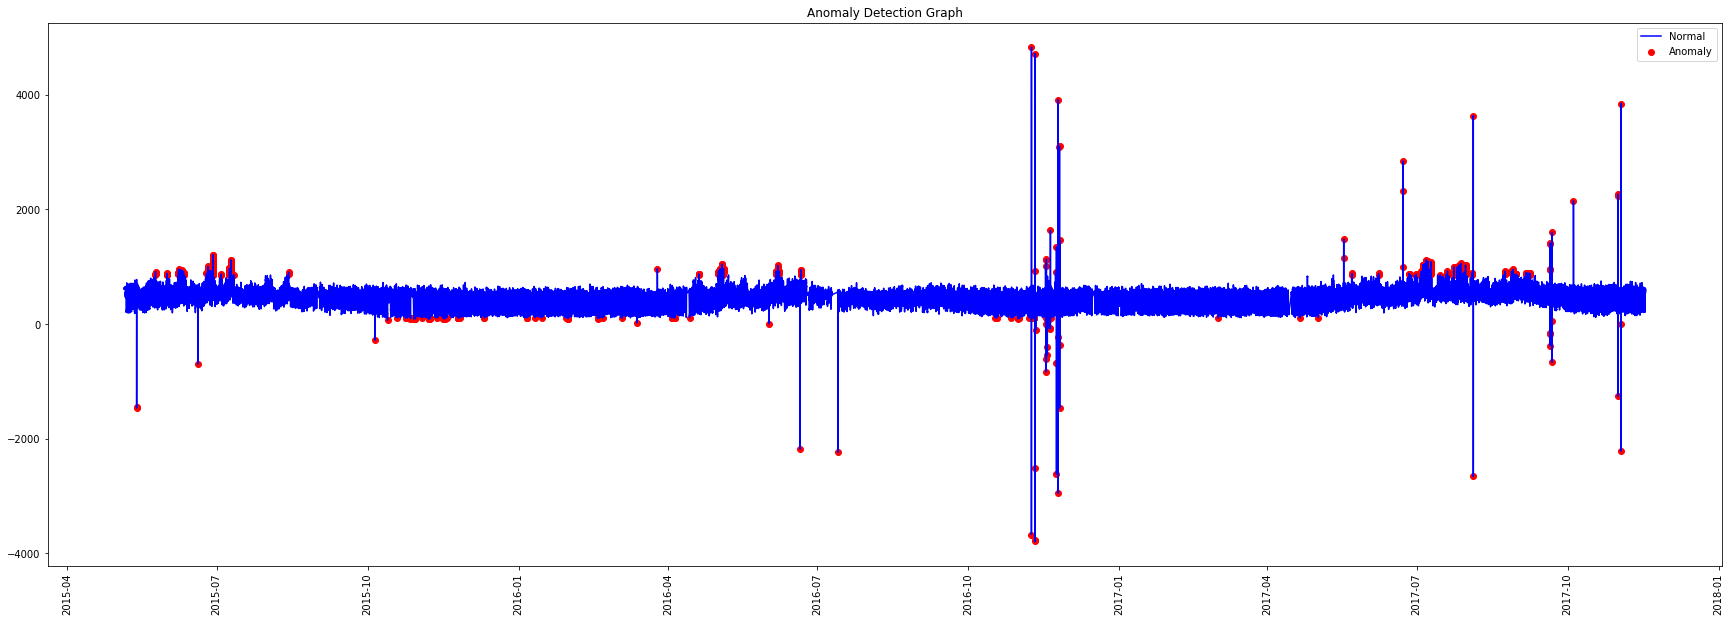

In [0]:
# convert datetime to number for easier plotting
df_ad['mdate'] = mdates.date2num(df_ad.DATE_TIME.dt.to_pydatetime())

# visualization, the blue line represent the "normal" data points while the red dots represent the anomalies that exist in the original data
fig, ax = plt.subplots(figsize=(30,10))
plt.locator_params(nbins=10, axis = 'x')

ax.scatter(df_ad.loc[df_ad.anomaly_data == -1, ['mdate']],df_ad.loc[df_ad.anomaly_data == -1, ['Total_Demand lag 0']], color='red', label = 'Anomaly', zorder=2)
ax.plot(df_ad.loc[:,['Total_Demand lag 0']], color='blue', label = 'Normal', zorder=2)

plt.xticks(rotation=90)
plt.title('Anomaly Detection Graph')
plt.legend()
plt.show()